# iZone Survey Data Cleaning Notebook

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

file_path = '../data/raw/form_response.csv'
output_path = '../data/processed/cleaned_data.csv'

print("Dependencies imported successfully.")

Dependencies imported successfully.


# 1. Data Loading and Inspection

In [5]:
def load_and_inspect_data(file_path):
    print("1. LOADING DATA")
    print("-" * 20)
    
    df = pd.read_csv(file_path)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Total responses: {df.shape[0]}")
    print(f"Total questions: {df.shape[1]}")
    
    print("\nColumn names:")
    for i, col in enumerate(df.columns, 1):
        print(f"{i:2d}. {col}")
    
    empty_rows = df.isnull().all(axis=1).sum()
    print(f"\nCompletely empty rows: {empty_rows}")
    
    print(f"\nData types:")
    print(df.dtypes.value_counts())
    
    return df


# 2. Column Renaming and Standardization

In [6]:
def rename_columns(df):
    """
    Rename columns to shorter, more manageable names
    """
    print("\n2. COLUMN RENAMING")
    print("-" * 20)
    
    column_mapping = {
        'Timestamp': 'timestamp',
        'What is your current affiliation with Sunway': 'affiliation',
        'If you are a current student, which year of study are you in?': 'study_year',
        'If you are an alumnus/alumna, which period best describes your graduation year? ': 'graduation_period',
        'Which faculty/school grouping are/were you primarily associated with at Sunway? ': 'faculty',
        'How frequently do you (or did you, as a student) use the iZone portal?': 'usage_frequency',
        'Overall, how satisfied are you with your current (or past) experience using the iZone portal?': 'overall_satisfaction',
        'What are the main tasks you use (or used) the iZone portal for? (Select all that apply)': 'main_tasks',
        'Which of the following aspects of the current iZone portal do you find MOST USEFUL or appreciate the most? (Select up to 3)': 'most_useful',
        'Which of the following aspects of the current iZone portal cause the MOST FRUSTRATION or are most CHALLENGING for you? (Select up to 3) ': 'most_frustrating',
        'How often have you experienced STABILITY issues with iZone (e.g., crashes, errors, unexpected logouts)?': 'stability_issues',
        'If you have experienced performance or stability issues, which of the following have you encountered? (Select all that apply)': 'performance_issues',
        'How would you rate the overall LOOK AND FEEL (visual design) of the current iZone portal?': 'ui_design_rating',
        'Is the iZone portal easy to use on your MOBILE DEVICE (phone/tablet)? ': 'mobile_usability',
        'Would you find it beneficial if iZone offered better integration of your academic CALENDAR (classes, deadlines, events) with personal calendar apps (e.g., Google Calendar, Outlook Calendar)? ': 'calendar_integration',
        'How satisfied are you with the way ATTENDANCE information is presented and accessed in iZone': 'attendance_satisfaction',
        'How easy or difficult is it to find important ANNOUNCEMENTS, news, and updates on iZone? ': 'announcements_ease',
        'If you have used iZone for making FEE PAYMENTS, how would you rate your experience? ': 'fee_payment_rating',
        'Would you be interested in opportunities to provide more detailed feedback, participate in usability testing, or contribute ideas for future iZone enhancements? ': 'feedback_interest',
        'From the list below, please select the TOP 3 areas you feel are MOST IMPORTANT for us to focus on when enhancing the iZone portal': 'top_priorities'
    }
    
    df_renamed = df.rename(columns=column_mapping)
    
    print("Columns renamed successfully!")
    print(f"New column names: {list(df_renamed.columns)}")
    
    return df_renamed

# 3. Timestamp Processing

In [7]:
def process_timestamp(df):
    print("\n3. TIMESTAMP PROCESSING")
    print("-" * 25)
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Extract date components
    df['survey_date'] = df['timestamp'].dt.date
    df['survey_hour'] = df['timestamp'].dt.hour
    df['survey_day_of_week'] = df['timestamp'].dt.day_name()
    
    invalid_timestamps = df['timestamp'].isnull().sum()
    print(f"Invalid timestamps: {invalid_timestamps}")
    
    if invalid_timestamps == 0:
        print(f"Survey period: {df['timestamp'].min()} to {df['timestamp'].max()}")
        print(f"Survey duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")
    
    return df


# 4. Categorical Data Cleaning

In [8]:
def clean_categorical_data(df):
    """
    Clean and standardize categorical responses
    """
    print("\n4. CATEGORICAL DATA CLEANING")
    print("-" * 30)
    
    # Define expected values for each categorical column
    categorical_mappings = {
        'affiliation': {
            'expected': ['Current Sunway University Student', 'Current Sunway College Student', 
                        'Sunway University Alumnus/Alumna', 'Sunway College Alumnus/Alumna'],
            'clean_func': lambda x: x.strip() if pd.notna(x) else x
        },
        'study_year': {
            'expected': ['Foundation / Pre-University', 'Year 1 (Undergraduate)', 
                        'Year 2 (Undergraduate)', 'Year 3 (Undergraduate)', 
                        'Year 4+ (Undergraduate)', 'Postgraduate'],
            'clean_func': lambda x: x.strip() if pd.notna(x) else x
        },
        'graduation_period': {
            'expected': ['Within the last 2 years', '3-5 years ago', '6-10 years ago', 
                        'More than 10 years ago', 'Not Applicable'],
            'clean_func': lambda x: x.strip() if pd.notna(x) else x
        },
        'usage_frequency': {
            'expected': ['Daily', 'Several times a week', 'Once a week', 
                        'Several times a month', 'Rarely', 'I have never used it / Barely used it'],
            'clean_func': lambda x: x.strip() if pd.notna(x) else x
        },
        'stability_issues': {
            'expected': ['Very Often', 'Often', 'Sometimes', 'Rarely', 'Never'],
            'clean_func': lambda x: x.strip() if pd.notna(x) else x
        },
        'mobile_usability': {
            'expected': ['Yes, it\'s well optimized and easy to use', 'It\'s usable, but could be improved',
                        'It\'s difficult to use on mobile', 'I haven\'t tried using it on a mobile device'],
            'clean_func': lambda x: x.strip() if pd.notna(x) else x
        },
        'calendar_integration': {
            'expected': ['Yes, very beneficial', 'Yes, somewhat beneficial', 'Neutral',
                        'No, not very beneficial', 'No, not beneficial at all'],
            'clean_func': lambda x: x.strip() if pd.notna(x) else x
        },
        'feedback_interest': {
            'expected': ['Yes, I\'m very interested', 'Yes, I\'m somewhat interested', 
                        'Maybe', 'No, thank you'],
            'clean_func': lambda x: x.strip() if pd.notna(x) else x
        }
    }
    
    # Clean categorical columns
    for col, mapping in categorical_mappings.items():
        if col in df.columns:
            # Apply cleaning function
            df[col] = df[col].apply(mapping['clean_func'])
            
            # Check for unexpected values
            if df[col].notna().any():
                unique_values = df[col].dropna().unique()
                unexpected = [val for val in unique_values if val not in mapping['expected']]
                if unexpected:
                    print(f"⚠️  Unexpected values in {col}: {unexpected}")
    
    print("Categorical data cleaning completed!")
    return df


# 5. Process the Rating Scales

In [9]:
def process_rating_scales(df):
    print("\n5. RATING SCALE PROCESSING")
    print("-" * 28)
    
    rating_columns = [
        'overall_satisfaction',
        'ui_design_rating', 
        'attendance_satisfaction',
        'announcements_ease',
        'fee_payment_rating'
    ]
    
    for col in rating_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            invalid_ratings = df[col][(df[col] < 1) | (df[col] > 5)].count()
            if invalid_ratings > 0:
                print(f"⚠️  {col}: {invalid_ratings} values outside 1-5 range")
                
            df.loc[(df[col] < 1) | (df[col] > 5), col] = np.nan
            
            print(f"✓ {col}: Range {df[col].min():.0f}-{df[col].max():.0f}, "
                  f"Mean: {df[col].mean():.2f}, Missing: {df[col].isnull().sum()}")
    
    return df

# 6. Process Multi-Response

In [10]:
def process_multiselect_responses(df):
    print("\n6. MULTI-SELECT RESPONSE PROCESSING")
    print("-" * 37)
    
    # Define multi-select columns and their possible options
    multiselect_columns = {
        'main_tasks': [
            'Checking timetable / class schedule',
            'Viewing academic results / transcripts',
            'Checking attendance records',
            'Making fee payments',
            'Accessing university/college announcements & news',
            'Booking facilities (e.g., discussion rooms)',
            'Updating personal information'
        ],
        'most_useful': [
            'Timetable visibility',
            'Access to academic results',
            'Announcements and news updates',
            'Online fee payment facility',
            'Attendance tracking',
            'Centralized information point',
            'Mobile accessibility (if applicable)',
            'None of these are particularly useful to me'
        ],
        'most_frustrating': [
            'Slow loading speed / Poor performance',
            'Difficult to navigate / Find information',
            'Outdated look and feel (UI design)',
            'Poor mobile experience',
            'Frequent errors or system crashes',
            'Confusing layout of information',
            'Lack of important features',
            'Difficulty with specific tasks (e.g., fee payment, registration)',
            'I don\'t experience significant frustrations'
        ],
        'performance_issues': [
            'Slow page loading times',
            'System crashes or freezes',
            'Error messages appearing frequently',
            'Being unexpectedly logged out',
            'Features not working as expected',
            'Inconsistent performance',
            'I have not experienced significant issues'
        ],
        'top_priorities': [
            'Improving Performance and Stability',
            'Modernizing the User Interface (Look & Feel)',
            'Improving Ease of Use and Navigation (User Experience)',
            'Enhancing Timetable & Calendar features',
            'Improving the Attendance System',
            'Better Information Accessibility & Communication tools',
            'Streamlining the Fee Payment System',
            'Better Club/Society System Integration',
            'Improved Mobile Experience'
        ]
    }
    
    for col, options in multiselect_columns.items():
        if col in df.columns:
            print(f"\nProcessing {col}...")
            
            # Create binary columns for each option
            for option in options:
                # Create a safe column name
                safe_name = f"{col}__{option.replace('/', '_').replace('(', '').replace(')', '').replace(' ', '_').replace('.', '').replace(',', '').replace('&', 'and').lower()}"
                
                # Check if the option appears in the response
                df[safe_name] = df[col].astype(str).str.contains(re.escape(option), case=False, na=False).astype(int)
            
            # Count total selections per response
            df[f'{col}_count'] = df[col].astype(str).str.count(',') + 1
            df.loc[df[col].isnull(), f'{col}_count'] = 0
            
            print(f"✓ Created {len(options)} binary columns for {col}")
    
    return df


# 7. Process School / Faculty Demographic

In [11]:
def process_faculty_data(df):
    print("\n7. FACULTY/SCHOOL PROCESSING")
    print("-" * 30)
    
    if 'faculty' in df.columns:
        df['faculty'] = df['faculty'].astype(str).str.strip()
        
        # Simplification yay
        faculty_mapping = {
            'School of Arts / Communication / Design': 'Arts_Communication_Design',
            'Sunway Business School / Economics / Accounting': 'Business_Economics_Accounting',
            'School of Engineering and Technology / Computer Science / IT': 'Engineering_Technology_IT',
            'School of Hospitality and Service Management': 'Hospitality_Service',
            'School of Healthcare and Medical Sciences / Psychology': 'Healthcare_Medical_Psychology',
            'School of Mathematical Sciences': 'Mathematical_Sciences',
            'American Degree Transfer Program (ADTP)': 'ADTP',
            'Pre-University Programmes (e.g., A-Levels, Foundation)': 'Pre_University',
            'Other Faculty/School': 'Other',
            'Not Applicable / Prefer not to say': 'Not_Applicable'
        }
        
        df['faculty_simplified'] = df['faculty'].map(faculty_mapping)
        
        # Check for unmapped values
        unmapped = df[df['faculty_simplified'].isnull() & df['faculty'].notna()]['faculty'].unique()
        if len(unmapped) > 0:
            print(f"⚠️  Unmapped faculty values: {unmapped}")
        
        print(f"✓ Faculty distribution:")
        print(df['faculty_simplified'].value_counts())
    
    return df


# 8. Data Quality Assessment

In [12]:
def assess_data_quality(df):
    print("\n8. DATA QUALITY ASSESSMENT")
    print("-" * 28)
    
    # Calculate response rates for key questions
    key_questions = [
        'affiliation', 'usage_frequency', 'overall_satisfaction', 
        'main_tasks', 'most_useful', 'most_frustrating'
    ]
    
    print("Response rates for key questions:")
    for col in key_questions:
        if col in df.columns:
            response_rate = (df[col].notna().sum() / len(df)) * 100
            print(f"  {col}: {response_rate:.1f}%")
    
    # Check for potential data quality issues
    print("\nData Quality Issues:")
    
    # Check for duplicate timestamps (potential duplicate responses)
    duplicate_timestamps = df['timestamp'].duplicated().sum()
    if duplicate_timestamps > 0:
        print(f"⚠️  {duplicate_timestamps} duplicate timestamps found")
    
    # Check for responses with very low completion rates
    non_null_cols = df.select_dtypes(include=['object', 'int64', 'float64']).columns
    completion_rates = df[non_null_cols].notna().sum(axis=1) / len(non_null_cols)
    low_completion = (completion_rates < 0.5).sum()
    if low_completion > 0:
        print(f"⚠️  {low_completion} responses with <50% completion rate")
    
    # Check for inconsistent responses
    alumni_mask = df['affiliation'].str.contains('Alumnus/Alumna', na=False)
    alumni_with_study_year = df[alumni_mask & df['study_year'].notna()]
    if len(alumni_with_study_year) > 0:
        print(f"⚠️  {len(alumni_with_study_year)} alumni responses have study year data")
    
    return df


# 9. Export Cleaned Data

In [13]:
def export_cleaned_data(df, output_path):
    print("\n9. EXPORTING CLEANED DATA")
    print("-" * 27)
    
    # Create summary statistics
    summary_stats = {
        'total_responses': len(df),
        'valid_responses': df['overall_satisfaction'].notna().sum(),
        'date_range': f"{df['timestamp'].min()} to {df['timestamp'].max()}",
        'response_rate_key_questions': {}
    }
    
    # Calculate response rates for key questions
    key_questions = ['affiliation', 'usage_frequency', 'overall_satisfaction', 'main_tasks']
    for col in key_questions:
        if col in df.columns:
            summary_stats['response_rate_key_questions'][col] = (df[col].notna().sum() / len(df)) * 100
    
    # Export main dataset
    df.to_csv(output_path, index=False)
    print(f"✓ Cleaned data exported to: {output_path}")
    
    # Export summary report
    summary_path = output_path.replace('.csv', '_summary.txt')
    with open(summary_path, 'w') as f:
        f.write("iZone Survey Data Cleaning Summary\n")
        f.write("=" * 40 + "\n\n")
        f.write(f"Total Responses: {summary_stats['total_responses']}\n")
        f.write(f"Valid Responses: {summary_stats['valid_responses']}\n")
        f.write(f"Date Range: {summary_stats['date_range']}\n\n")
        f.write("Response Rates for Key Questions:\n")
        for col, rate in summary_stats['response_rate_key_questions'].items():
            f.write(f"  {col}: {rate:.1f}%\n")
    
    print(f"✓ Summary report exported to: {summary_path}")
    
    return summary_stats

# 10. Visualization

In [14]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def create_data_quality_visualizations(df):
    print("\n10. CREATING DATA QUALITY VISUALIZATIONS")
    print("-" * 42)
    
    # Ensure the directory exists
    os.makedirs("../media", exist_ok=True)
    
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('iZone Survey Data Quality Assessment', fontsize=16, fontweight='bold')
    
    # 1. Response completion rate
    non_null_cols = df.select_dtypes(include=['object', 'int64', 'float64']).columns
    completion_rates = df[non_null_cols].notna().sum(axis=1) / len(non_null_cols) * 100
    
    axes[0, 0].hist(completion_rates, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Response Completion Rate Distribution')
    axes[0, 0].set_xlabel('Completion Rate (%)')
    axes[0, 0].set_ylabel('Number of Responses')
    axes[0, 0].axvline(completion_rates.mean(), color='red', linestyle='--', 
                      label=f'Mean: {completion_rates.mean():.1f}%')
    axes[0, 0].legend()
    
    # 2. Missing data heatmap for key columns
    key_cols = ['affiliation', 'usage_frequency', 'overall_satisfaction', 'main_tasks', 
                'most_useful', 'most_frustrating', 'ui_design_rating']
    missing_data = df[key_cols].isnull()
    
    im = axes[0, 1].imshow(missing_data.T, cmap='RdYlBu_r', aspect='auto')
    axes[0, 1].set_title('Missing Data Pattern (Key Questions)')
    axes[0, 1].set_xlabel('Response Index')
    axes[0, 1].set_ylabel('Questions')
    axes[0, 1].set_yticks(range(len(key_cols)))
    axes[0, 1].set_yticklabels([col.replace('_', ' ').title() for col in key_cols])
    
    # 3. Response distribution by affiliation
    if 'affiliation' in df.columns:
        affiliation_counts = df['affiliation'].value_counts()
        axes[1, 0].bar(range(len(affiliation_counts)), affiliation_counts.values, 
                      color='lightgreen', alpha=0.7)
        axes[1, 0].set_title('Response Distribution by Affiliation')
        axes[1, 0].set_xlabel('Affiliation')
        axes[1, 0].set_ylabel('Number of Responses')
        axes[1, 0].set_xticks(range(len(affiliation_counts)))
        axes[1, 0].set_xticklabels([label.replace(' ', '\n') for label in affiliation_counts.index], 
                                  rotation=45, ha='right')
    
    # 4. Survey responses over time
    if 'timestamp' in df.columns:
        df['survey_date'] = pd.to_datetime(df['timestamp']).dt.date
        daily_responses = df['survey_date'].value_counts().sort_index()
        
        axes[1, 1].plot(daily_responses.index, daily_responses.values, 
                       marker='o', linewidth=2, markersize=4, color='orange')
        axes[1, 1].set_title('Survey Responses Over Time')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Number of Responses')
        axes[1, 1].tick_params(axis='x', rotation=45)

    # Save to file before showing
    save_path = "../media/data_quality_visualizations.png"
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    fig.savefig(save_path)
    plt.show()

    print(f"✓ Data quality visualizations created and saved to: {save_path}")


## Cleaning Pipeline
The main_cleaning_pipeline() function serves as the entry point for executing all cleaning steps in sequence. It takes a raw survey .csv file, applies the full set of preprocessing functions, exports the cleaned dataset, and generates quality diagnostics. Use this to run the entire cleaning workflow end-to-end with a single call.

In [15]:
def main_cleaning_pipeline(input_file_path, output_file_path=None):
    if output_file_path is None:
        output_file_path = input_file_path.replace('.csv', '_cleaned.csv')
    
    print("STARTING iZone SURVEY DATA CLEANING PIPELINE")
    print("=" * 50)
    
    try:
        # Execute cleaning steps
        df = load_and_inspect_data(input_file_path)
        df = rename_columns(df)
        df = process_timestamp(df)
        df = clean_categorical_data(df)
        df = process_rating_scales(df)
        df = process_multiselect_responses(df)
        df = process_faculty_data(df)
        df = assess_data_quality(df)
        
        # Export results
        summary_stats = export_cleaned_data(df, output_file_path)
        
        # Create visualizations
        create_data_quality_visualizations(df)
        
        print("\n" + "=" * 50)
        print("DATA CLEANING PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 50)
        print(f"Cleaned dataset: {output_file_path}")
        print(f"Total responses processed: {len(df)}")
        print(f"Data quality: {summary_stats['valid_responses']}/{len(df)} complete responses")
        
        return df
        
    except Exception as e:
        print(f"❌ Error in cleaning pipeline: {str(e)}")
        raise


# Cleaning

STARTING iZone SURVEY DATA CLEANING PIPELINE
1. LOADING DATA
--------------------
Dataset shape: (287, 20)
Total responses: 287
Total questions: 20

Column names:
 1. Timestamp
 2. What is your current affiliation with Sunway
 3. If you are a current student, which year of study are you in?
 4. If you are an alumnus/alumna, which period best describes your graduation year? 
 5. Which faculty/school grouping are/were you primarily associated with at Sunway? 
 6. How frequently do you (or did you, as a student) use the iZone portal?
 7. Overall, how satisfied are you with your current (or past) experience using the iZone portal?
 8. What are the main tasks you use (or used) the iZone portal for? (Select all that apply)
 9. Which of the following aspects of the current iZone portal do you find MOST USEFUL or appreciate the most? (Select up to 3)
10. Which of the following aspects of the current iZone portal cause the MOST FRUSTRATION or are most CHALLENGING for you? (Select up to 3) 
11. 

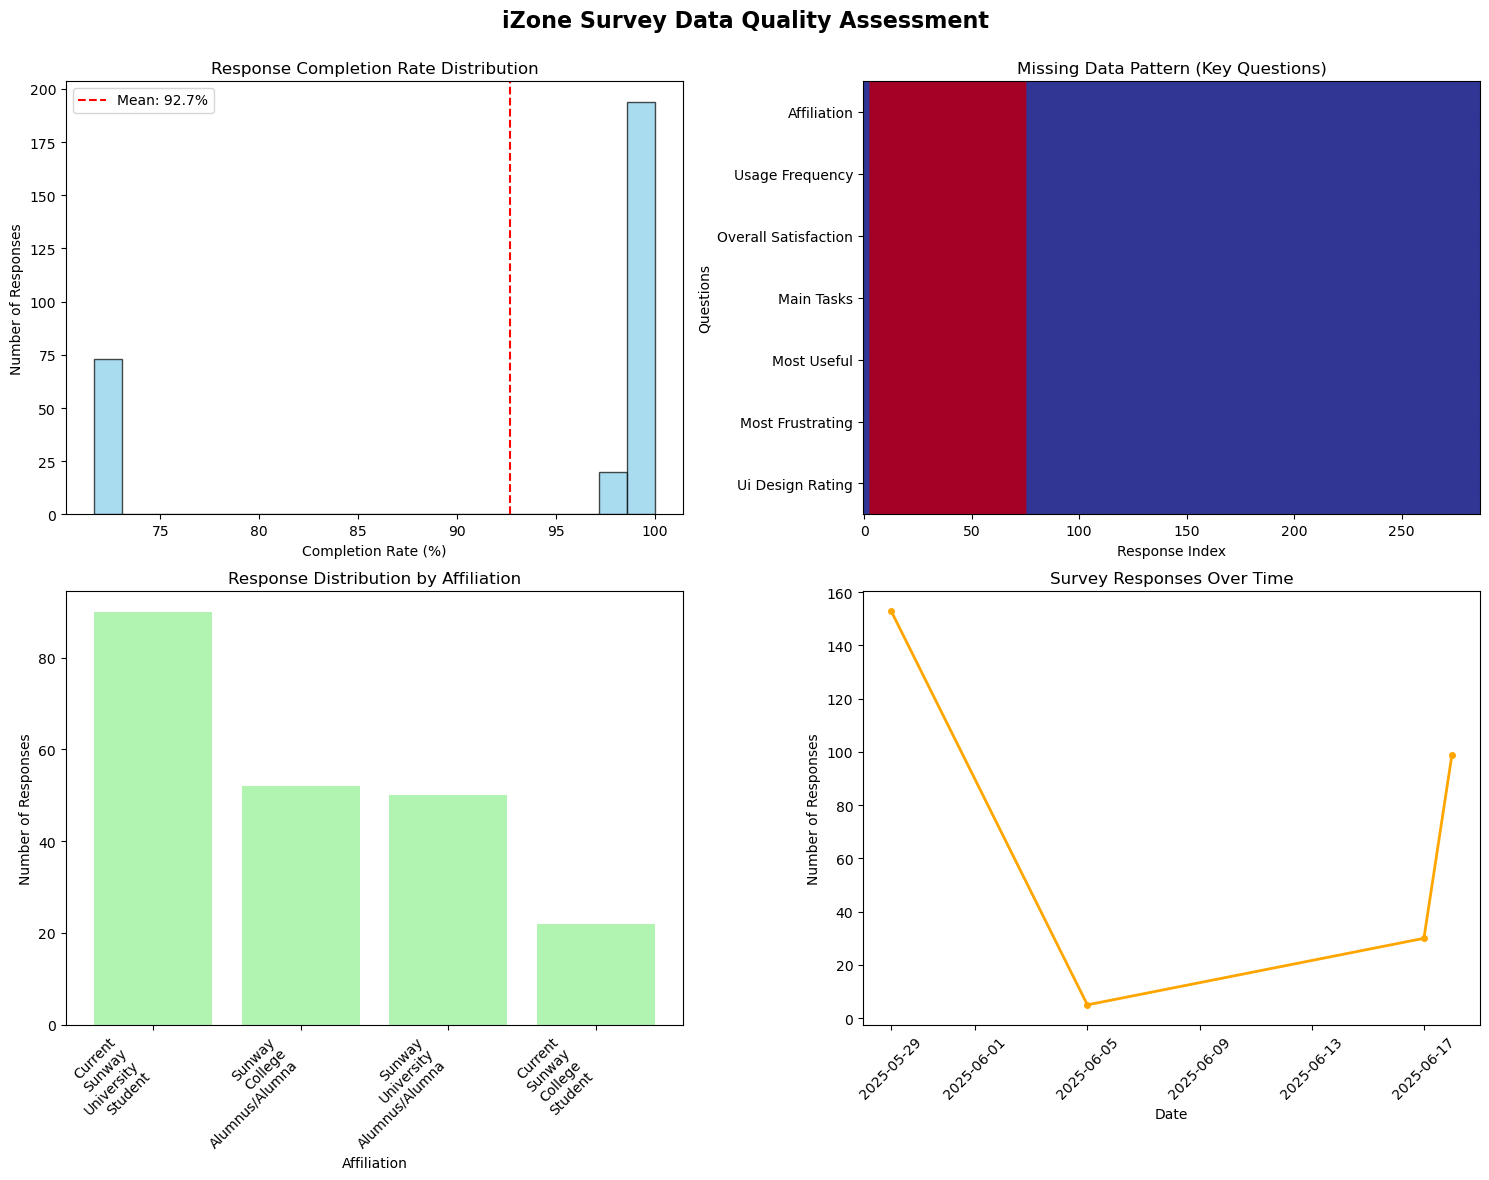

✓ Data quality visualizations created and saved to: ../media/data_quality_visualizations.png

DATA CLEANING PIPELINE COMPLETED SUCCESSFULLY!
Cleaned dataset: ../data/processed/cleaned_data.csv
Total responses processed: 287
Data quality: 214/287 complete responses


,timestamp,affiliation,study_year,graduation_period,faculty,usage_frequency,overall_satisfaction,main_tasks,most_useful,most_frustrating,stability_issues,performance_issues,ui_design_rating,mobile_usability,calendar_integration,attendance_satisfaction,announcements_ease,fee_payment_rating,feedback_interest,top_priorities,survey_date,survey_hour,survey_day_of_week,main_tasks__checking_timetable___class_schedule,main_tasks__viewing_academic_results___transcripts,main_tasks__checking_attendance_records,main_tasks__making_fee_payments,main_tasks__accessing_university_college_announcements_and_news,main_tasks__booking_facilities_eg_discussion_rooms,main_tasks__updating_personal_information,main_tasks_count,most_useful__timetable_visibility,most_useful__access_to_academic_results,most_useful__announcements_and_news_updates,most_useful__online_fee_payment_facility,most_useful__attendance_tracking,most_useful__centralized_information_point,most_useful__mobile_accessibility_if_applicable,most_useful__none_of_these_are_particularly_useful_to_me,most_useful_count,most_frustrating__slow_loading_speed___poor_performance,most_frustrating__difficult_to_navigate___find_information,most_frustrating__outdated_look_and_feel_ui_design,most_frustrating__poor_mobile_experience,most_frustrating__frequent_errors_or_system_crashes,most_frustrating__confusing_layout_of_information,most_frustrating__lack_of_important_features,most_frustrating__difficulty_with_specific_tasks_eg_fee_payment_registration,most_frustrating__i_don't_experience_significant_frustrations,most_frustrating_count,performance_issues__slow_page_loading_times,performance_issues__system_crashes_or_freezes,performance_issues__error_messages_appearing_frequently,performance_issues__being_unexpectedly_logged_out,performance_issues__features_not_working_as_expected,performance_issues__inconsistent_performance,performance_issues__i_have_not_experienced_significant_issues,performance_issues_count,top_priorities__improving_performance_and_stability,top_priorities__modernizing_the_user_interface_look_and_feel,top_priorities__improving_ease_of_use_and_navigation_user_experience,top_priorities__enhancing_timetable_and_calendar_features,top_priorities__improving_the_attendance_system,top_priorities__better_information_accessibility_and_communication_tools,top_priorities__streamlining_the_fee_payment_system,top_priorities__better_club_society_system_integration,top_priorities__improved_mobile_experience,top_priorities_count,faculty_simplified
0,2025-05-29 02:58:00,Sunway College Alumnus/Alumna,Year 1 (Undergraduate),Within the last 2 years,"Pre-University Programmes (e.g., A-Levels, Foundation)",Daily,4.0,"Checking timetable / class schedule, Checking attendance records, Accessing university/college a...","Timetable visibility, Attendance tracking","Outdated look and feel (UI design), Lack of important features",Never,I have not experienced significant issues,1.0,"Yes, it's well optimized and easy to use","Yes, very beneficial",2.0,1.0,4.0,Maybe,"Modernizing the User Interface (Look & Feel), Improving Ease of Use and Navigation (User Experie...",2025-05-29,2,Thursday,1,0,1,0,1,0,0,3,1,0,0,0,1,0,0,0,2,0,0,1,0,0,0,1,0,0,2,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,4,Pre_University
1,2025-05-29 02:59:22,Sunway College Alumnus/Alumna,Year 1 (Undergraduate),Within the last 2 years,"Pre-University Programmes (e.g., A-Levels, Foundation)",Daily,4.0,"Checking timetable / class schedule, Checking attendance records, Accessing university/college a...","Timetable visibility, Attendance tracking","Outdated look and feel (UI design), Lack of important features",Never,I have not experienced significant issues,1.0,"Yes, it's well optimized and easy to use","Yes, very beneficial",2.0,1.0,4.0,Maybe,"Modernizing the User Interface (Look & Feel), Improving Ease of Use and Navigation (User Experie...",2025-05-29,2,Thursday,1,0,1,0,1,0,0,3,1,0,0,0,1,0,0,0,2,0,0,1,0,0,0,1,0,0,2,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,4,Pre_University

In [16]:
main_cleaning_pipeline(file_path, output_path)